In [2]:
import numpy as np
import pandas as pd
import os
import plotly.express as px

import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import optuna
import time
from sklearn.metrics import *
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import lightgbm as lgb

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Загрузка данных

In [3]:
path_true = '/kaggle/input/fake-news-detection-datasets/News _dataset/True.csv'
path_fake = '/kaggle/input/fake-news-detection-datasets/News _dataset/Fake.csv'

data_true = pd.read_csv(path_true)
data_fake = pd.read_csv(path_fake)

print(f'Размерность датасета с реальными новостями = {data_true.shape}')
print(f'Размерность датасета с фейковыми новостями = {data_fake.shape}')      

Размерность датасета с реальными новостями = (21417, 4)
Размерность датасета с фейковыми новостями = (23481, 4)


In [4]:
data_true['label'] = 1  # реальные 
data_fake['label'] = 0  # фейковые новости

# объединяем новости в один датасет
df = pd.concat([data_true, data_fake], ignore_index=True)

# вносим случайности в таблицу
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f'Размерность объединённого датасета = {df.shape}')   

Размерность объединённого датасета = (44898, 5)


### Предварительный анализ данных

In [5]:
print("INFO:")
df.info()

INFO:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB


In [6]:
print("Первые строки:")
df.head(3)

Первые строки:


,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",0


In [7]:
print("Количество пропусков в столбцах")
print(df.isna().sum())

Количество пропусков в столбцах
title      0
text       0
subject    0
date       0
label      0
dtype: int64


In [8]:
print(f"Количество явных дубликатов по полным строкам = {df.duplicated().sum()}")
print(f"Количество явных дубликатов по заголовку+тексту = {df.duplicated(subset=['title', 'text']).sum()}")

Количество явных дубликатов по полным строкам = 209
Количество явных дубликатов по заголовку+тексту = 5793


In [9]:
# избавляемся сразу от дубликатов по заголовку + тексту
print('Размерность объединённого датасета')
print(f'- До удаления = {df.shape}')
df = df.drop_duplicates(subset=['title', 'text']).reset_index(drop=True)
print(f'- После удаления дубликатов = {df.shape}')

Размерность объединённого датасета
- До удаления = (44898, 5)
- После удаления дубликатов = (39105, 5)


In [10]:
# смотрим типы данных
df.dtypes

title      object
text       object
subject    object
date       object
label       int64
dtype: object

In [11]:
# переводим дату в datetime с учётом разных форматов
df['date'] = pd.to_datetime(
    df['date'].astype(str).str.strip(),
    format='mixed',
    errors='coerce'  # некорректные даты станут NaT
)

print(df['date'].dtype)
print("Пропусков в date:", df['date'].isna().sum())
print("Диапазон дат:", df['date'].min(), "→", df['date'].max())

datetime64[ns]
Пропусков в date: 6
Диапазон дат: 2015-03-31 00:00:00 → 2018-02-19 00:00:00


In [12]:
print(df.dtypes)
df.sample(1) 

title              object
text               object
subject            object
date       datetime64[ns]
label               int64
dtype: object


,title,text,subject,date,label
531,[VIDEO] RUBIO GETS WALLOPED IN FL…Blames GOP E...,,politics,2016-03-15,0


### EDA

In [13]:
# изучим целевую переменную 
print("Распределение классов таргета")
print(df['label'].value_counts())
print(df['label'].value_counts(normalize=True).round(3))

Распределение классов таргета
label
1    21197
0    17908
Name: count, dtype: int64
label
1    0.542
0    0.458
Name: proportion, dtype: float64


In [14]:
target_counts = df['label'].value_counts().reset_index()
target_counts.columns = ['label', 'count']  # явно задаём имена колонок

target_counts['class_name'] = target_counts['label'].map({0: 'Fake', 1: 'Real'})

fig = px.bar(
    target_counts,
    x='class_name',
    y='count',
    title='Распределение классов таргета',
    labels={'class_name': 'Класс', 'count': 'Количество новостей'},
    text='count'
)
fig.update_traces(textposition='outside')
fig.update_layout(yaxis_title='Количество', xaxis_title='Класс')
fig.show()

In [15]:
df['weekday'] = df['date'].dt.weekday  # 0=Mon, 6=Sun

weekday_map = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df['weekday_name'] = df['weekday'].map(weekday_map)
order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

weekday_ct = pd.crosstab(df['weekday_name'], df['label'], normalize='index').round(3)
weekday_ct.columns = ['Fake', 'Real']

weekday_ct = weekday_ct.loc[order]
print(weekday_ct)

               Fake   Real
weekday_name              
Mon           0.452  0.548
Tue           0.415  0.585
Wed           0.400  0.600
Thu           0.402  0.598
Fri           0.419  0.581
Sat           0.657  0.343
Sun           0.626  0.374


In [16]:
# Heatmap доли фейков/реальных по дням недели
fig = px.imshow(
    weekday_ct.values,
    x=['Fake', 'Real'],
    y=weekday_ct.index,
    title='Доля fake/real по дням недели',
    color_continuous_scale='RdYlGn_r',
    text_auto=True,
    aspect='auto'
)
fig.show()

In [17]:
# Группировка по месяцам и классам
monthly_cls = (
    df
    .groupby([df['date'].dt.to_period('M'), 'label'])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)
monthly_cls['date'] = monthly_cls['date'].dt.to_timestamp()
monthly_cls = monthly_cls.rename(columns={0: 'Fake', 1: 'Real'})

In [18]:
fig = px.line(
    monthly_cls,
    x='date',
    y=['Fake', 'Real'],
    title='Количество новостей по месяцам: Fake vs Real',
    labels={'date': 'Месяц', 'value': 'Количество новостей', 'variable': 'Класс'},
    markers=True
)
fig.update_layout(xaxis_tickangle=-45, hovermode='x unified')
fig.show()

In [19]:
subj_counts = df['subject'].value_counts().reset_index()
subj_counts.columns = ['subject', 'count'] 

fig = px.bar(
    subj_counts,
    x='subject',
    y='count',
    title='Распределение тем новостей',
    labels={'subject':'Тема', 'count':'Количество новостей'}
)
fig.update_layout(xaxis_tickangle=-30)
fig.show()

In [20]:
subj_ct = pd.crosstab(df['subject'], df['label'])
subj_ct.columns = ['Fake', 'Real']

top_subjects = df['subject'].value_counts().index
subj_ct_top = subj_ct.loc[top_subjects]
print(subj_ct_top)

                 Fake   Real
subject                     
politicsNews        0  11213
worldnews           0   9984
News             9050      0
politics         4645      0
left-news        2496      0
Government News   934      0
US_News           396      0
Middle-east       387      0


In [21]:
fig = px.bar(
    subj_ct_top.reset_index(),
    x='subject',
    y=['Fake', 'Real'],
    barmode='group',
    title='Количество Fake/Real новостей по темам',
    labels={'subject':'Тема', 'value':'Количество новостей', 'variable':'Класс'}
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [22]:
df['title_len'] = df['title'].astype(str).str.len()
df['text_len'] = df['text'].astype(str).str.len()
df['title_words'] = df['title'].astype(str).str.split().str.len()
df['text_words'] = df['text'].astype(str).str.split().str.len()

print("Длины текстов")
print(df[['title_len', 'text_len', 'title_words', 'text_words']].describe().round(1))

Длины текстов
       title_len  text_len  title_words  text_words
count    39105.0   39105.0      39105.0     39105.0
mean        76.8    2428.0         12.0       398.5
std         22.3    1943.3          3.7       315.0
min          8.0       1.0          1.0         0.0
25%         62.0    1267.0          9.0       208.0
50%         71.0    2211.0         11.0       366.0
75%         87.0    3080.0         14.0       508.0
max        286.0   51794.0         42.0      8135.0


In [23]:
fig = px.histogram(
    df,
    x='title_words',
    nbins=40,
    title='Распределение длины заголовков (в словах)',
    labels={'title_words':'Количество слов'}
)
fig.show()

fig = px.histogram(
    df,
    x='text_words',
    nbins=40,
    title='Распределение длины текстов (в словах)',
    labels={'text_words':'Количество слов'}
)
fig.show()

In [24]:
fig = px.box(
    df,
    x='label',
    y='title_words',
    points='outliers',
    title='Длина заголовков по классам',
    labels={'label':'Класс (0=Fake, 1=Real)', 'title_words':'Количество слов'}
)
fig.update_xaxes(tickvals=[0,1], ticktext=['Fake','Real'])
fig.show()

fig = px.box(
    df,
    x='label',
    y='text_words',
    points='outliers',
    title='Длина текстов по классам',
    labels={'label':'Класс (0=Fake, 1=Real)', 'text_words':'Количество слов'}
)
fig.update_xaxes(tickvals=[0,1], ticktext=['Fake','Real'])
fig.show()

In [25]:
print("Текстов с text_words > 3000:", (df['text_words'] > 3000).sum())
print("Текстов с text_words > 5000:", (df['text_words'] > 5000).sum())

Текстов с text_words > 3000: 60
Текстов с text_words > 5000: 14


In [26]:
before = df.shape[0]

df = df[df['text_words'] <= 3000].reset_index(drop=True)

after = df.shape[0]
print(f"Размерность после удаления выбросов по длине текста: {before} → {after}")

Размерность после удаления выбросов по длине текста: 39105 → 39045


In [27]:
fig = px.histogram(
    df,
    x='text_words',
    nbins=40,
    title='Распределение длины текстов (в словах)',
    labels={'text_words':'Количество слов'}
)
fig.show()

In [28]:
fig = px.box(
    df,
    x='label',
    y='title_words',
    points='outliers',
    title='Длина заголовков по классам',
    labels={'label':'Класс (0=Fake, 1=Real)', 'title_words':'Количество слов'}
)
fig.update_xaxes(tickvals=[0,1], ticktext=['Fake','Real'])
fig.show()

fig = px.box(
    df,
    x='label',
    y='text_words',
    points='outliers',
    title='Длина текстов по классам',
    labels={'label':'Класс (0=Fake, 1=Real)', 'text_words':'Количество слов'}
)
fig.update_xaxes(tickvals=[0,1], ticktext=['Fake','Real'])
fig.show()

In [29]:
def clean_for_wc(text):
    if pd.isna(text):
        return ""
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', ' ', text) 
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['title_wc'] = df['title'].apply(clean_for_wc)
df['text_wc'] = df['text'].apply(clean_for_wc)

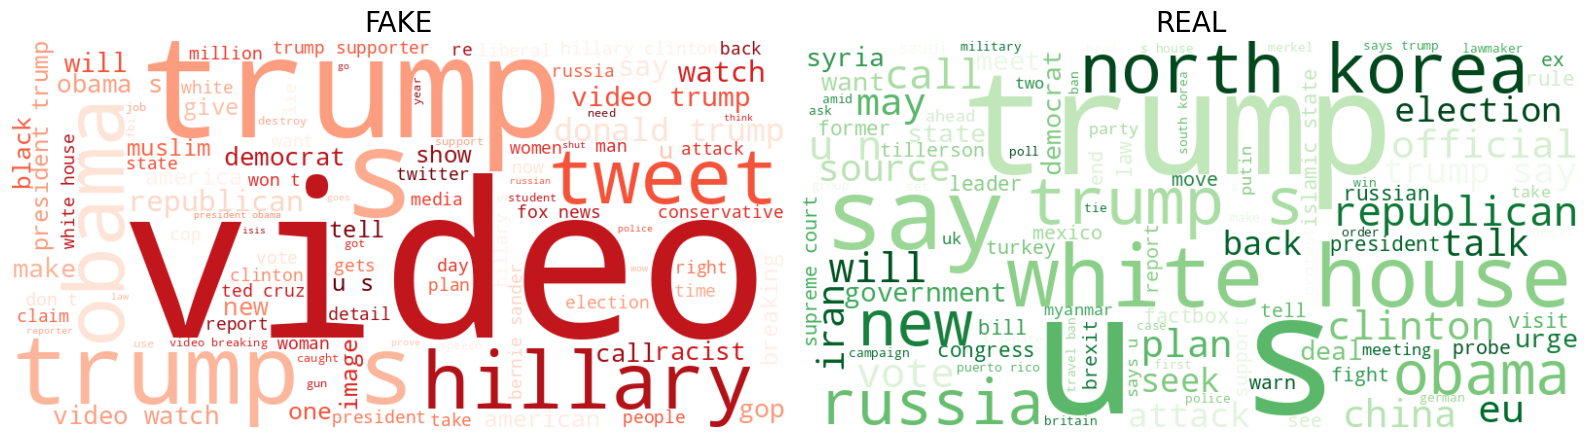

In [30]:
fake_title_text = ' '.join(df[df['label']==0]['title_wc'])
real_title_text = ' '.join(df[df['label']==1]['title_wc'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

wc_fake_title = WordCloud(width=800, height=400, background_color='white',
                          colormap='Reds', max_words=100).generate(fake_title_text)
axes[0].imshow(wc_fake_title, interpolation='bilinear')
axes[0].set_title('FAKE', fontsize=20)
axes[0].axis('off')

wc_real_title = WordCloud(width=800, height=400, background_color='white',
                          colormap='Greens', max_words=100).generate(real_title_text)
axes[1].imshow(wc_real_title, interpolation='bilinear')
axes[1].set_title('REAL', fontsize=20)
axes[1].axis('off')

plt.tight_layout()
plt.savefig('wordcloud_titles_fake_real.png', dpi=300, bbox_inches='tight')
plt.show()

### Подготовка данных к построению моделей

In [31]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

SOURCE_TOKENS = {
    'reuters',
    'reutersipsos',
    'getty',
    'zerohedge',
    'zero',
    'hedge',
    'century',
    'wire'
}

def clean_text(text):
    text = str(text).lower()

    # убираем во избежание утечки целевой
    patterns = [
        r'reuters',
        r'image via',
        r'image credit',
        r'getty images?',
        r'zero hedge',
        r'century wire'
    ]
    for p in patterns:
        text = re.sub(p, ' ', text)

    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))

    tokens = text.split()
    tokens = [
        w for w in tokens
        if w not in stop_words
        and w not in SOURCE_TOKENS
        and len(w) > 2
    ]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return ' '.join(tokens)

df['text_full'] = (df['title'].fillna('') + ' ' + df['text'].fillna('')).str.strip()
df['text_clean'] = df['text_full'].apply(clean_text)
df['text_clean'].head(2)

0    breaking gop chairman grassley enough demand t...
1    failed gop candidate remembered hilarious mock...
Name: text_clean, dtype: object

#### Разбиение данных на обучающую, тестовую и валидационную выборки

In [32]:
X = df['text_clean']
y = df['label']

# 70 / 30
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# 70 / 15 / 15
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(len(X_train), len(X_val), len(X_test))

27331 5857 5857


In [33]:
tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    min_df=5
)
tfidf

TfidfVectorizer(max_features=50000, min_df=5, ngram_range=(1, 2))

### Построение моделей 

In [34]:
pipelines = {}

pipelines['logreg'] = Pipeline([
    ('tfidf', tfidf),
    ('clf', LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    ))
])

pipelines['tree'] = Pipeline([
    ('tfidf', tfidf),
    ('clf', DecisionTreeClassifier(
        max_depth=50,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42
    ))
])

pipelines['rf'] = Pipeline([
    ('tfidf', tfidf),
    ('clf', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=3,
        class_weight='balanced_subsample',
        n_jobs=-1,
        random_state=42
    ))
])

pipelines['lgbm'] = Pipeline([
    ('tfidf', tfidf),
    ('clf', lgb.LGBMClassifier(
        objective='binary',
        n_estimators=300,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        is_unbalance=True,  
        n_jobs=-1,
        random_state=42
    ))
])

####   Оптимизируем через Optuna

In [75]:
def create_tfidf(trial):
    max_features = trial.suggest_int('tfidf_max_features', 20000, 80000, step=20000)
    ngram_max = trial.suggest_int('tfidf_ngram_max', 1, 2)
    return TfidfVectorizer(
        max_features=max_features,
        ngram_range=(1, ngram_max),
        min_df=5
    )

def objective_logreg(trial):
    tfidf = create_tfidf(trial)
    C = trial.suggest_float('C', 1e-3, 10.0, log=True)

    model = LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        n_jobs=-1,
        C=C,
        random_state=42
    )

    pipe = Pipeline([('tfidf', tfidf), ('clf', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    return f1_score(y_val, y_pred)

def objective_tree(trial):
    tfidf = create_tfidf(trial)
    max_depth = trial.suggest_int('max_depth', 10, 80, step=10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        class_weight='balanced',
        random_state=42
    )

    pipe = Pipeline([('tfidf', tfidf), ('clf', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    return f1_score(y_val, y_pred)

def objective_rf(trial):
    tfidf = create_tfidf(trial)
    n_estimators = trial.suggest_int('n_estimators', 200, 600, step=100)
    max_depth = trial.suggest_int('max_depth', 10, 80, step=10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_leaf=min_samples_leaf,
        class_weight='balanced_subsample',
        n_jobs=-1,
        random_state=42
    )

    pipe = Pipeline([('tfidf', tfidf), ('clf', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    return f1_score(y_val, y_pred)

def objective_lgbm(trial):
    tfidf = create_tfidf(trial)
    n_estimators = trial.suggest_int('n_estimators', 150, 400, step=50)
    num_leaves = trial.suggest_int('num_leaves', 16, 64)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.1, log=True)
    max_depth = trial.suggest_int('max_depth', -1, 10)
    subsample = trial.suggest_float('subsample', 0.6, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)

    model = lgb.LGBMClassifier(
        objective='binary',
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        num_leaves=num_leaves,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        is_unbalance=True,
        n_jobs=-1,
        random_state=42
    )

    pipe = Pipeline([('tfidf', tfidf), ('clf', model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    return f1_score(y_val, y_pred)


In [76]:
n_trials = 15  # быстрая настройка

objectives = {
    'logreg': objective_logreg,
    'tree': objective_tree,
    'rf': objective_rf,
    'lgbm': objective_lgbm
}

studies = {}

for name, obj in objectives.items():
    print(f'\n=== Optuna for {name} ===')
    study = optuna.create_study(direction='maximize')
    study.optimize(obj, n_trials=n_trials, show_progress_bar=False)
    print('Best F1:', study.best_value)
    print('Best params:', study.best_params)
    studies[name] = study

[I 2025-12-11 09:53:13,837] A new study created in memory with name: no-name-75555f44-000c-4ff2-860f-eb2c16cb3079



=== Optuna for logreg ===


[I 2025-12-11 09:53:51,497] Trial 0 finished with value: 0.9649671567094151 and parameters: {'tfidf_max_features': 60000, 'tfidf_ngram_max': 2, 'C': 0.053980353101638845}. Best is trial 0 with value: 0.9649671567094151.
[I 2025-12-11 09:54:00,422] Trial 1 finished with value: 0.961906254898887 and parameters: {'tfidf_max_features': 20000, 'tfidf_ngram_max': 1, 'C': 0.039778809011659776}. Best is trial 0 with value: 0.9649671567094151.
[I 2025-12-11 09:54:37,230] Trial 2 finished with value: 0.9429514380009429 and parameters: {'tfidf_max_features': 80000, 'tfidf_ngram_max': 2, 'C': 0.00874791908649402}. Best is trial 0 with value: 0.9649671567094151.
[I 2025-12-11 09:55:14,252] Trial 3 finished with value: 0.9874568830354343 and parameters: {'tfidf_max_features': 40000, 'tfidf_ngram_max': 2, 'C': 3.439290982804748}. Best is trial 3 with value: 0.9874568830354343.
[I 2025-12-11 09:55:50,306] Trial 4 finished with value: 0.986524600438734 and parameters: {'tfidf_max_features': 20000, 'tfi

Best F1: 0.9888627450980393
Best params: {'tfidf_max_features': 40000, 'tfidf_ngram_max': 2, 'C': 9.236345701184677}

=== Optuna for tree ===


[I 2025-12-11 10:01:04,884] Trial 0 finished with value: 0.9242352941176472 and parameters: {'tfidf_max_features': 60000, 'tfidf_ngram_max': 1, 'max_depth': 30, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.9242352941176472.
[I 2025-12-11 10:01:51,965] Trial 1 finished with value: 0.9259837601499064 and parameters: {'tfidf_max_features': 80000, 'tfidf_ngram_max': 1, 'max_depth': 70, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9259837601499064.
[I 2025-12-11 10:02:15,107] Trial 2 finished with value: 0.9263059701492538 and parameters: {'tfidf_max_features': 20000, 'tfidf_ngram_max': 1, 'max_depth': 20, 'min_samples_leaf': 7}. Best is trial 2 with value: 0.9263059701492538.
[I 2025-12-11 10:02:47,894] Trial 3 finished with value: 0.9227629513343799 and parameters: {'tfidf_max_features': 20000, 'tfidf_ngram_max': 1, 'max_depth': 50, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.9263059701492538.
[I 2025-12-11 10:03:12,738] Trial 4 finished with value: 0.928794503

Best F1: 0.931704260651629
Best params: {'tfidf_max_features': 60000, 'tfidf_ngram_max': 2, 'max_depth': 40, 'min_samples_leaf': 3}

=== Optuna for rf ===


[I 2025-12-11 10:13:15,830] Trial 0 finished with value: 0.9664074650077761 and parameters: {'tfidf_max_features': 80000, 'tfidf_ngram_max': 2, 'n_estimators': 500, 'max_depth': 10, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.9664074650077761.
[I 2025-12-11 10:14:55,016] Trial 1 finished with value: 0.9810205351586807 and parameters: {'tfidf_max_features': 80000, 'tfidf_ngram_max': 2, 'n_estimators': 300, 'max_depth': 60, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9810205351586807.
[I 2025-12-11 10:15:50,652] Trial 2 finished with value: 0.9777362603144948 and parameters: {'tfidf_max_features': 40000, 'tfidf_ngram_max': 2, 'n_estimators': 200, 'max_depth': 70, 'min_samples_leaf': 7}. Best is trial 1 with value: 0.9810205351586807.
[I 2025-12-11 10:16:23,167] Trial 3 finished with value: 0.9729813664596274 and parameters: {'tfidf_max_features': 40000, 'tfidf_ngram_max': 1, 'n_estimators': 400, 'max_depth': 20, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.98

Best F1: 0.9814785992217899
Best params: {'tfidf_max_features': 60000, 'tfidf_ngram_max': 2, 'n_estimators': 400, 'max_depth': 80, 'min_samples_leaf': 3}

=== Optuna for lgbm ===
[LightGBM] [Info] Number of positive: 14834, number of negative: 12497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 5.921411 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1089438
[LightGBM] [Info] Number of data points in the train set: 27331, number of used features: 19769
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542754 -> initscore=0.171433
[LightGBM] [Info] Start training from score 0.171433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

[I 2025-12-11 10:30:35,392] Trial 0 finished with value: 0.935069008782936 and parameters: {'tfidf_max_features': 20000, 'tfidf_ngram_max': 2, 'n_estimators': 200, 'num_leaves': 49, 'learning_rate': 0.013368773630702378, 'max_depth': 4, 'subsample': 0.6501885470428485, 'colsample_bytree': 0.7393375516494708}. Best is trial 0 with value: 0.935069008782936.


[LightGBM] [Info] Number of positive: 14834, number of negative: 12497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 12.079510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1259699
[LightGBM] [Info] Number of data points in the train set: 27331, number of used features: 36481
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542754 -> initscore=0.171433
[LightGBM] [Info] Start training from score 0.171433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-12-11 10:32:29,543] Trial 1 finished with value: 0.9771660932123866 and parameters: {'tfidf_max_features': 40000, 'tfidf_ngram_max': 2, 'n_estimators': 200, 'num_leaves': 57, 'learning_rate': 0.05123310625305121, 'max_depth': 5, 'subsample': 0.6228647455082313, 'colsample_bytree': 0.8640438758163258}. Best is trial 1 with value: 0.9771660932123866.


[LightGBM] [Info] Number of positive: 14834, number of negative: 12497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 14.691869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1263650
[LightGBM] [Info] Number of data points in the train set: 27331, number of used features: 36973
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542754 -> initscore=0.171433
[LightGBM] [Info] Start training from score 0.171433


[I 2025-12-11 10:35:36,873] Trial 2 finished with value: 0.9834063869755791 and parameters: {'tfidf_max_features': 80000, 'tfidf_ngram_max': 2, 'n_estimators': 250, 'num_leaves': 40, 'learning_rate': 0.0319589488295086, 'max_depth': 10, 'subsample': 0.6884147742999056, 'colsample_bytree': 0.7410474630323739}. Best is trial 2 with value: 0.9834063869755791.


[LightGBM] [Info] Number of positive: 14834, number of negative: 12497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.835215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 833968
[LightGBM] [Info] Number of data points in the train set: 27331, number of used features: 14207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542754 -> initscore=0.171433
[LightGBM] [Info] Start training from score 0.171433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2025-12-11 10:36:51,703] Trial 3 finished with value: 0.9560456749569842 and parameters: {'tfidf_max_features': 60000, 'tfidf_ngram_max': 1, 'n_estimators': 350, 'num_leaves': 46, 'learning_rate': 0.011829228301861568, 'max_depth': 5, 'subsample': 0.7227620782511331, 'colsample_bytree': 0.7233865524489489}. Best is trial 2 with value: 0.9834063869755791.


[LightGBM] [Info] Number of positive: 14834, number of negative: 12497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.958744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 833968
[LightGBM] [Info] Number of data points in the train set: 27331, number of used features: 14207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542754 -> initscore=0.171433
[LightGBM] [Info] Start training from score 0.171433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-12-11 10:37:26,353] Trial 4 finished with value: 0.9601001408230324 and parameters: {'tfidf_max_features': 40000, 'tfidf_ngram_max': 1, 'n_estimators': 200, 'num_leaves': 48, 'learning_rate': 0.04567432242739505, 'max_depth': 3, 'subsample': 0.8781339991185246, 'colsample_bytree': 0.7554148541564218}. Best is trial 2 with value: 0.9834063869755791.


[LightGBM] [Info] Number of positive: 14834, number of negative: 12497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 12.141423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1259699
[LightGBM] [Info] Number of data points in the train set: 27331, number of used features: 36481
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542754 -> initscore=0.171433
[LightGBM] [Info] Start training from score 0.171433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

[I 2025-12-11 10:39:02,083] Trial 5 finished with value: 0.9284588717302238 and parameters: {'tfidf_max_features': 40000, 'tfidf_ngram_max': 2, 'n_estimators': 350, 'num_leaves': 63, 'learning_rate': 0.015102718761356807, 'max_depth': 2, 'subsample': 0.7959040522096914, 'colsample_bytree': 0.7177322879801395}. Best is trial 2 with value: 0.9834063869755791.


[LightGBM] [Info] Number of positive: 14834, number of negative: 12497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 3.758210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 833968
[LightGBM] [Info] Number of data points in the train set: 27331, number of used features: 14207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542754 -> initscore=0.171433
[LightGBM] [Info] Start training from score 0.171433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-12-11 10:40:03,866] Trial 6 finished with value: 0.9777289836888332 and parameters: {'tfidf_max_features': 80000, 'tfidf_ngram_max': 1, 'n_estimators': 300, 'num_leaves': 53, 'learning_rate': 0.03958254466600036, 'max_depth': 5, 'subsample': 0.6289014022815803, 'colsample_bytree': 0.7499781545898815}. Best is trial 2 with value: 0.9834063869755791.


[LightGBM] [Info] Number of positive: 14834, number of negative: 12497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 5.564154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1089438
[LightGBM] [Info] Number of data points in the train set: 27331, number of used features: 19769
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542754 -> initscore=0.171433
[LightGBM] [Info] Start training from score 0.171433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[I 2025-12-11 10:41:49,386] Trial 7 finished with value: 0.980883735506111 and parameters: {'tfidf_max_features': 20000, 'tfidf_ngram_max': 2, 'n_estimators': 150, 'num_leaves': 60, 'learning_rate': 0.05696826036816284, 'max_depth': 8, 'subsample': 0.9091911406483287, 'colsample_bytree': 0.7105505661415954}. Best is trial 2 with value: 0.9834063869755791.


[LightGBM] [Info] Number of positive: 14834, number of negative: 12497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 3.865432 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 833968
[LightGBM] [Info] Number of data points in the train set: 27331, number of used features: 14207
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542754 -> initscore=0.171433
[LightGBM] [Info] Start training from score 0.171433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

[I 2025-12-11 10:42:26,485] Trial 8 finished with value: 0.9509742300439975 and parameters: {'tfidf_max_features': 80000, 'tfidf_ngram_max': 1, 'n_estimators': 350, 'num_leaves': 29, 'learning_rate': 0.03152212638560117, 'max_depth': 2, 'subsample': 0.7149760374068903, 'colsample_bytree': 0.9208069716744027}. Best is trial 2 with value: 0.9834063869755791.


[LightGBM] [Info] Number of positive: 14834, number of negative: 12497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 5.569269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1089438
[LightGBM] [Info] Number of data points in the train set: 27331, number of used features: 19769
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542754 -> initscore=0.171433
[LightGBM] [Info] Start training from score 0.171433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

[I 2025-12-11 10:43:43,286] Trial 9 finished with value: 0.9744874002191265 and parameters: {'tfidf_max_features': 20000, 'tfidf_ngram_max': 2, 'n_estimators': 400, 'num_leaves': 51, 'learning_rate': 0.0634265795845409, 'max_depth': 2, 'subsample': 0.8267667734645756, 'colsample_bytree': 0.7828159951561351}. Best is trial 2 with value: 0.9834063869755791.


[LightGBM] [Info] Number of positive: 14834, number of negative: 12497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 13.001693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1263635
[LightGBM] [Info] Number of data points in the train set: 27331, number of used features: 36973
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542754 -> initscore=0.171433
[LightGBM] [Info] Start training from score 0.171433


[I 2025-12-11 10:46:00,873] Trial 10 finished with value: 0.9729306837740572 and parameters: {'tfidf_max_features': 60000, 'tfidf_ngram_max': 2, 'n_estimators': 250, 'num_leaves': 16, 'learning_rate': 0.02368800954837889, 'max_depth': 10, 'subsample': 0.9860229318389053, 'colsample_bytree': 0.6260690301920735}. Best is trial 2 with value: 0.9834063869755791.


[LightGBM] [Info] Number of positive: 14834, number of negative: 12497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 12.227837 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1263650
[LightGBM] [Info] Number of data points in the train set: 27331, number of used features: 36973
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542754 -> initscore=0.171433
[LightGBM] [Info] Start training from score 0.171433


[I 2025-12-11 10:48:04,690] Trial 11 finished with value: 0.986842105263158 and parameters: {'tfidf_max_features': 80000, 'tfidf_ngram_max': 2, 'n_estimators': 150, 'num_leaves': 34, 'learning_rate': 0.09565031851533226, 'max_depth': 10, 'subsample': 0.950187597537364, 'colsample_bytree': 0.6435400446361437}. Best is trial 11 with value: 0.986842105263158.


[LightGBM] [Info] Number of positive: 14834, number of negative: 12497
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 12.566735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1263650
[LightGBM] [Info] Number of data points in the train set: 27331, number of used features: 36973
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542754 -> initscore=0.171433
[LightGBM] [Info] Start training from score 0.171433


[I 2025-12-11 10:50:40,802] Trial 12 finished with value: 0.9899749373433584 and parameters: {'tfidf_max_features': 80000, 'tfidf_ngram_max': 2, 'n_estimators': 150, 'num_leaves': 34, 'learning_rate': 0.0901807577985578, 'max_depth': -1, 'subsample': 0.9951971057335475, 'colsample_bytree': 0.6013332053784128}. Best is trial 12 with value: 0.9899749373433584.


[LightGBM] [Info] Number of positive: 14834, number of negative: 12497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 12.301849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1263635
[LightGBM] [Info] Number of data points in the train set: 27331, number of used features: 36973
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542754 -> initscore=0.171433
[LightGBM] [Info] Start training from score 0.171433


[I 2025-12-11 10:52:58,492] Trial 13 finished with value: 0.9887218045112782 and parameters: {'tfidf_max_features': 60000, 'tfidf_ngram_max': 2, 'n_estimators': 150, 'num_leaves': 32, 'learning_rate': 0.09530378452244638, 'max_depth': -1, 'subsample': 0.9982608297381093, 'colsample_bytree': 0.6086139309678894}. Best is trial 12 with value: 0.9899749373433584.


[LightGBM] [Info] Number of positive: 14834, number of negative: 12497
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 12.762799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1263635
[LightGBM] [Info] Number of data points in the train set: 27331, number of used features: 36973
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542754 -> initscore=0.171433
[LightGBM] [Info] Start training from score 0.171433


[I 2025-12-11 10:55:09,977] Trial 14 finished with value: 0.9884085213032581 and parameters: {'tfidf_max_features': 60000, 'tfidf_ngram_max': 2, 'n_estimators': 150, 'num_leaves': 25, 'learning_rate': 0.0955404690962811, 'max_depth': -1, 'subsample': 0.9875648325974099, 'colsample_bytree': 0.6057000990088978}. Best is trial 12 with value: 0.9899749373433584.


Best F1: 0.9899749373433584
Best params: {'tfidf_max_features': 80000, 'tfidf_ngram_max': 2, 'n_estimators': 150, 'num_leaves': 34, 'learning_rate': 0.0901807577985578, 'max_depth': -1, 'subsample': 0.9951971057335475, 'colsample_bytree': 0.6013332053784128}


In [77]:
best_params = {}

for name, study in studies.items():
    params = study.best_params.copy()
    params['F1_val'] = study.best_value
    best_params[name] = params

rows = []
for model, params in best_params.items():
    row = {'model': model}
    row.update(params)
    rows.append(row)

best_df = pd.DataFrame(rows)
best_df

,model,tfidf_max_features,tfidf_ngram_max,C,F1_val,max_depth,min_samples_leaf,n_estimators,num_leaves,learning_rate,subsample,colsample_bytree
0,logreg,40000,2,9.236346,0.988863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tree,60000,2,NaN,0.931704,40.0,3.0,NaN,NaN,NaN,NaN,NaN
2,rf,60000,2,NaN,0.981479,80.0,3.0,400.0,NaN,NaN,NaN,NaN
3,lgbm,80000,2,NaN,0.989975,-1.0,NaN,150.0,34.0,0.090181,0.995197,0.601333


In [79]:
final_results = {}

X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

for _, row in best_df.iterrows():
    name = row['model']
    print(f'\n=== Final {name} ===')

    tfidf = TfidfVectorizer(
        max_features=int(row['tfidf_max_features']),
        ngram_range=(1, int(row['tfidf_ngram_max'])),
        min_df=5
    )

    if name == 'logreg':
        clf = LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            n_jobs=-1,
            C=row['C'],
            random_state=42
        )
    elif name == 'tree':
        clf = DecisionTreeClassifier(
            max_depth=int(row['max_depth']),
            min_samples_leaf=int(row['min_samples_leaf']),
            class_weight='balanced',
            random_state=42
        )
    elif name == 'rf':
        clf = RandomForestClassifier(
            n_estimators=int(row['n_estimators']),
            max_depth=int(row['max_depth']),
            min_samples_leaf=int(row['min_samples_leaf']),
            class_weight='balanced_subsample',
            n_jobs=-1,
            random_state=42
        )
    elif name == 'lgbm':
        clf = lgb.LGBMClassifier(
            objective='binary',
            n_estimators=int(row['n_estimators']),
            learning_rate=row['learning_rate'],
            num_leaves=int(row['num_leaves']),
            max_depth=int(row['max_depth']),
            subsample=row['subsample'],
            colsample_bytree=row['colsample_bytree'],
            is_unbalance=True,
            n_jobs=-1,
            random_state=42
        )

    pipe = Pipeline([('tfidf', tfidf), ('clf', clf)])

    # время обучения
    t0 = time.time()
    pipe.fit(X_train_full, y_train_full)
    train_time = time.time() - t0

    # время инференса на тесте
    t0 = time.time()
    y_test_pred = pipe.predict(X_test)
    infer_time = time.time() - t0

    f1 = f1_score(y_test, y_test_pred)
    print(f'F1 (test) = {f1:.3f}')
    print(f'Train time: {train_time:.2f} s')
    print(f'Inference time (test): {infer_time:.2f} s')
    print(classification_report(y_test, y_test_pred))

    final_results[name] = {
        'F1_val_best': row['F1_val'],
        'F1_test': f1,
        'train_time_sec': train_time,
        'infer_time_sec': infer_time
    }

final_df = pd.DataFrame.from_dict(final_results, orient='index').reset_index().rename(columns={'index': 'model'})
final_df


=== Final logreg ===
F1 (test) = 0.989
Train time: 41.99 s
Inference time (test): 2.94 s
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2678
           1       0.99      0.99      0.99      3179

    accuracy                           0.99      5857
   macro avg       0.99      0.99      0.99      5857
weighted avg       0.99      0.99      0.99      5857


=== Final tree ===
F1 (test) = 0.929
Train time: 85.95 s
Inference time (test): 2.72 s
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      2678
           1       0.93      0.93      0.93      3179

    accuracy                           0.92      5857
   macro avg       0.92      0.92      0.92      5857
weighted avg       0.92      0.92      0.92      5857


=== Final rf ===
F1 (test) = 0.980
Train time: 115.38 s
Inference time (test): 4.03 s
              precision    recall  f1-score   support

           0       0.98   

,model,F1_val_best,F1_test,train_time_sec,infer_time_sec
0,logreg,0.988863,0.989183,41.993576,2.937894
1,tree,0.931704,0.929299,85.950685,2.724969
2,rf,0.981479,0.979509,115.377601,4.031763
3,lgbm,0.989975,0.988852,195.136334,2.788831


In [82]:
fig = px.bar(
    final_df,
    x='model',
    y='F1_test',
    title='F1 на тестовой выборке для разных моделей',
    labels={'model': 'Модель', 'F1_test': 'F1 (test)'},
    text='F1_test'
)
fig.update_traces(texttemplate='%{text:.4f}', textposition='outside')
fig.update_layout(yaxis_range=[0.92, 1.0])
fig.show()

# График времени обучения
fig = px.bar(
    final_df,
    x='model',
    y='train_time_sec',
    title='Время обучения моделей',
    labels={'model': 'Модель', 'train_time_sec': 'Время обучения, с'},
    text='train_time_sec'
)
fig.update_traces(texttemplate='%{text:.1f}', textposition='outside')
fig.show()

In [81]:
fig = px.bar(
    final_df,
    x='model',
    y='infer_time_sec',
    title='Время инференса на тестовой выборке',
    labels={'model': 'Модель', 'infer_time_sec': 'Время инференса, с'},
    text='infer_time_sec'
)
fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
fig.show()

По целевой метрике лучшие - логистическая регрессия и lgbm. Но по времени эффективнее логрег, поэтому останавливаемся на ней как на самом оптимальном варианте.

In [40]:
tfidf_final = TfidfVectorizer(
    max_features=40000,
    ngram_range=(1, 2),
    min_df=5
)

logreg_final = LogisticRegression(
    max_iter=2000,
    class_weight='balanced',
    n_jobs=-1,
    C=9.236346,
    solver='lbfgs',
    random_state=42
)

logreg_pipe = Pipeline([
    ('tfidf', tfidf_final),
    ('clf', logreg_final)
])

# train + val
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

t0 = time.time()
logreg_pipe.fit(X_train_full, y_train_full)
train_time = time.time() - t0

t0 = time.time()
y_test_pred = logreg_pipe.predict(X_test)
infer_time = time.time() - t0

acc = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
prec = precision_score(y_test, y_test_pred)
rec = recall_score(y_test, y_test_pred)

print('Final Logistic Regression')
print(f'Accuracy: {acc:.4f}')
print(f'F1:       {f1:.4f}')
print(f'Precision:{prec:.4f}')
print(f'Recall:   {rec:.4f}')
print(f'Train time:   {train_time:.2f} s')
print(f'Inference time (test): {infer_time:.2f} s')
print('\nClassification report:')
print(classification_report(y_test, y_test_pred))

Final Logistic Regression
Accuracy: 0.9882
F1:       0.9892
Precision:0.9859
Recall:   0.9925
Train time:   37.02 s
Inference time (test): 2.26 s

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2678
           1       0.99      0.99      0.99      3179

    accuracy                           0.99      5857
   macro avg       0.99      0.99      0.99      5857
weighted avg       0.99      0.99      0.99      5857



##### Примеры работы модели на тестовых данных

In [38]:
# 5 случайных индексов из тестовой выборки
np.random.seed(42)
idx = np.random.choice(len(X_test), size=5, replace=False)

X_sample = X_test.iloc[idx]
y_true_sample = y_test.iloc[idx].to_numpy()
y_pred_sample = logreg_pipe.predict(X_sample)

for i, (text, yt, yp) in enumerate(zip(X_sample, y_true_sample, y_pred_sample)):
    print(f'\n=== Пример {i+1} ===')
    print('Истинный класс:', yt, '(0 = fake, 1 = real)')
    print('Предсказанный класс:', int(yp))
    print('Текст (очищенный, первые 500 символов):')
    print(text[:500], '...')


=== Пример 1 ===
Истинный класс: 0 (0 = fake, 1 = real)
Предсказанный класс: 0
Текст (очищенный, первые 500 символов):
bill o’reilly screw fox news shocking amount advertiser abandon network tweet one fox news biggest successful news personality bringing network major wayrecently reilly factor host bill reilly exposed massive amount sexual harassment lawsuit network settled span career fox already gained quite reputation sexist culture tendency protect people sexual harassment allegation damaging enough network reputation looking like network also suffer big financial hitso far beginning many advertiser pulled a ...

=== Пример 2 ===
Истинный класс: 0 (0 = fake, 1 = real)
Предсказанный класс: 0
Текст (очищенный, первые 500 символов):
trump embarrassed candidate lost he’s deleting tweet praying you’ll forget donald trump went man luther strange mean tweeted pressing matter course least dozen time support incumbent senator alabamaor least strange incumbent former chief justice alabama s

In [39]:
tfidf_log = logreg_pipe.named_steps['tfidf']
logreg_clf = logreg_pipe.named_steps['clf']

feature_names = tfidf_log.get_feature_names_out()
coefs = logreg_clf.coef_[0]  # бинарная классификация

# положительные коэффициенты → сдвиг к классу 1 (real)
N = 20

top_pos_idx = coefs.argsort()[::-1][:N]
top_neg_idx = coefs.argsort()[:N]

print('Топ слов за класс 1 (real):')
for w, c in zip(feature_names[top_pos_idx], coefs[top_pos_idx]):
    print(f'{w:30s}  coef = {c:.4f}')

print('\nТоп слов за класс 0 (fake):')
for w, c in zip(feature_names[top_neg_idx], coefs[top_neg_idx]):
    print(f'{w:30s}  coef = {c:.4f}')

Топ слов за класс 1 (real):
said                            coef = 28.7902
president donald                coef = 13.1451
washington                      coef = 11.7028
it                              coef = 11.3842
we                              coef = 10.6892
tuesday                         coef = 10.3276
wednesday                       coef = 10.1015
the                             coef = 9.9299
thursday                        coef = 8.8298
friday                          coef = 7.8867
monday                          coef = 7.8650
that                            coef = 7.4372
nov                             coef = 7.3498
washington president            coef = 6.9075
said statement                  coef = 6.8647
president barack                coef = 6.6831
he                              coef = 6.3879
london                          coef = 6.1618
minister                        coef = 5.9516
moscow                          coef = 5.6130

Топ слов за класс 0 (fake):
video           

In [41]:
N = 20
top_pos_idx = coefs.argsort()[::-1][:N]
top_neg_idx = coefs.argsort()[:N]

pos_df = pd.DataFrame({
    'word': feature_names[top_pos_idx],
    'coef': coefs[top_pos_idx],
    'class': 'real (1)'
})

neg_df = pd.DataFrame({
    'word': feature_names[top_neg_idx],
    'coef': coefs[top_neg_idx],
    'class': 'fake (0)'
})

coef_df = pd.concat([pos_df, neg_df], ignore_index=True)

fig = px.bar(
    coef_df.sort_values('coef'),
    x='coef',
    y='word',
    color='class',
    orientation='h',
    title='Наиболее важные слова для логистической регрессии',
    labels={'word': 'Слово / n-грамма', 'coef': 'Вес коэффициента'}
)
fig.update_layout(legend_title_text='Класс')
fig.show()

### Краткие выводы
Модель TF‑IDF + Logistic Regression достигает F1 ≈ 0.989 и accuracy ≈ 0.988 на отложенном тесте, при precision ≈ 0.986 и recall ≈ 0.993, что означает, что она почти не пропускает фейковые новости и крайне редко ошибочно помечает реальные как фейки.

По важным признакам отметим, что для реальных новостей модель опирается на, скажем, более повседневную новостную лексику и геополитический контекст (например, `said`, `washington`, дни недели, `president donald`, `minister`, `moscow`), характерные для агентских материалов, в то время как для фейков высокие по модулю отрицательные веса связаны с более эмоциональной и кликабельной лексикой (`video`, `breaking`, `watch`, `really`), что отражает типичную стилистику фейковых заголовков и текстов

**Зоны для улучшений:**

- Общая способность к обобщению.
Известно, что модели, обученные на ISOT, сильно теряют в качестве при переносе на другие наборы (другие темы/страны/платформы). Для повышения устойчивости нужно либо дообучать модель на разнородных данных, либо использовать более мощные представления (эмбеддинги, трансформеры).​

- Учёт контекста и сарказма.
Линейная модель с TF‑IDF плохо ловит тонкие контекстные признаки (ирония, скрытые намёки, сложные рассуждения). Здесь перспективны LSTM/Transformer‑архитектуры и мультимодальные подходы (текст + метаданные).

- Сокращение времени обучения для тяжёлых моделей. 
В сравнении с логистической регрессией, LGBM и Random Forest дают сопоставимое или немного хуже качество, но требуют существенно больше времени на обучение, что делает их менее удобными как базовая модель, хотя они могут использоваться в ансамблях.

**Функциональный эффект**   
Модель может автоматически фильтровать подавляющее большинство фейковых новостей до попадания к пользователю или модератору, значительно снижая нагрузку на ручную проверку и уменьшая риск распространения дезинформации; при скорости инференса порядка нескольких секунд на тысячи текстов её можно применять и в потоковом режиме.